Data import

In [1]:
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.utils import resample

import sklearn.metrics as metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string
import re
import nltk
import plotly.express as px

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


train_set = pd.read_csv('mediaeval-2015-trainingset.txt', sep='\t') #import train_set and add a tab seperator
test_set = pd.read_csv('mediaeval-2015-testset.txt', sep='\t') #import test_set and add a tab seperator

train_set.tail()

ModuleNotFoundError: No module named 'plotly'

Data Pre-proccessing

In [ ]:
train_set.info() #Overall quality and volume of the train dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14277 entries, 0 to 14276
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweetId     14277 non-null  int64 
 1   tweetText   14277 non-null  object
 2   userId      14277 non-null  int64 
 3   imageId(s)  14277 non-null  object
 4   username    14277 non-null  object
 5   timestamp   14277 non-null  object
 6   label       14277 non-null  object
dtypes: int64(2), object(5)
memory usage: 780.9+ KB


In [ ]:
#See how many values there are in 'label' Column
train_set['label'].value_counts()

fake     6742
real     4921
humor    2614
Name: label, dtype: int64

In [ ]:
test_set.tail()

,tweetId,tweetText,userId,imageId(s),username,timestamp,label
3750,578433150071775232,Un présentateur de la ZDF confesse avoir truqu...,257551211,varoufakis_1,Cdt_Sylvestre,Thu Mar 19 05:49:44 +0000 2015,fake
3751,578433646597656576,"Oh les kleine menteurs ""@CorineBarella: Un pré...",27575883,varoufakis_1,damomarc,Thu Mar 19 05:51:42 +0000 2015,fake
3752,578486910491996160,Este es el programa de ZDF en el que confirman...,2049211,varoufakis_1,javierpascual,Thu Mar 19 09:23:21 +0000 2015,fake
3753,578505023912591360,11.34 - wir haben FAST Mittag ▶ Riesen Verwirr...,262222386,varoufakis_1,aotto1968_2,Thu Mar 19 10:35:20 +0000 2015,fake
3754,578305144380612609,"Sorry, @yanisvaroufakis! https://t.co/BSkYrbII...",19072286,varoufakis_1,janboehm,Wed Mar 18 21:21:05 +0000 2015,fake


In [ ]:
test_set.info() #Overall quality and volume of the test dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweetId     3755 non-null   int64 
 1   tweetText   3755 non-null   object
 2   userId      3755 non-null   int64 
 3   imageId(s)  3755 non-null   object
 4   username    3755 non-null   object
 5   timestamp   3755 non-null   object
 6   label       3755 non-null   object
dtypes: int64(2), object(5)
memory usage: 205.5+ KB


In [ ]:
#See how many values there are in 'label' Column
test_set['label'].value_counts()

fake    2546
real    1209
Name: label, dtype: int64

In [ ]:
train_set.loc[train_set['label'] == 'humor', 'label'] = 'fake'  #update all 'humor' labels of train_set to fake

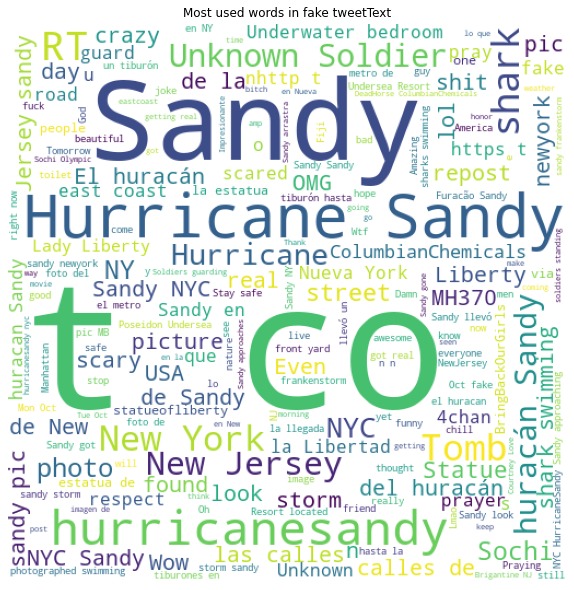

In [ ]:
#Find common words in fake posts
txt = ' '.join(list(train_set[train_set['label'] == 'fake']['tweetText']))

word_cloud = WordCloud(width=512, height=512, background_color="white").generate(txt)
plt.figure(figsize=(8,8))
plt.imshow(word_cloud)
plt.axis('off')
plt.title('Most used words in fake tweetText')
plt.tight_layout(pad=0)

#Save
#plt.savefig('Figures/common_fake_posts')
plt.show()

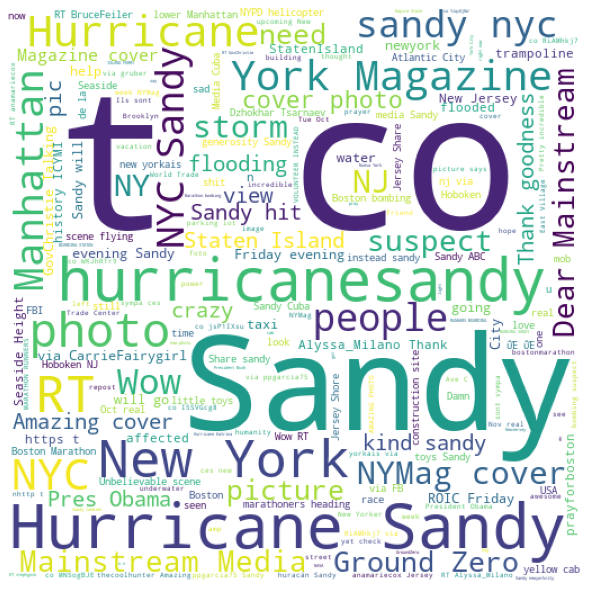

In [ ]:
#Find common words in true posts
txt2 = ' '.join(list(train_set[train_set['label'] == 'real']['tweetText']))

word_cloud = WordCloud(width=512, height=512, background_color="white").generate(txt2)
plt.figure(figsize=(8,8))
plt.imshow(word_cloud)
plt.axis('off')
#plt.title('Most used words in fake tweetText')
plt.tight_layout(pad=0)

#Save
#plt.savefig('Figures/common_true_posts')
plt.show()

Data Pre-processing

In [ ]:
#Map labels into numerical data
train_set['label'] = train_set['label'].map({'fake': 0, 'real': 1})
test_set['label'] = test_set['label'].map({'fake': 0, 'real': 1})

In [ ]:
#Lower case
train_set['cleantweetText'] = train_set['tweetText'].str.lower()
test_set['cleantweetText'] = test_set['tweetText'].str.lower()

In [ ]:
train_set.head()

,tweetId,tweetText,userId,imageId(s),username,timestamp,label,cleantweetText
0,263046056240115712,¿Se acuerdan de la película: “El día después d...,21226711,sandyA_fake_46,iAnnieM,Mon Oct 29 22:34:01 +0000 2012,0,¿se acuerdan de la película: “el día después d...
1,262995061304852481,@milenagimon: Miren a Sandy en NY! Tremenda i...,192378571,sandyA_fake_09,CarlosVerareal,Mon Oct 29 19:11:23 +0000 2012,0,@milenagimon: miren a sandy en ny! tremenda i...
2,262979898002534400,"Buena la foto del Huracán Sandy, me recuerda a...",132303095,sandyA_fake_09,LucasPalape,Mon Oct 29 18:11:08 +0000 2012,0,"buena la foto del huracán sandy, me recuerda a..."
3,262996108400271360,Scary shit #hurricane #NY http://t.co/e4JLBUfH,241995902,sandyA_fake_29,Haaaaarryyy,Mon Oct 29 19:15:33 +0000 2012,0,scary shit #hurricane #ny http://t.co/e4jlbufh
4,263018881839411200,My fave place in the world #nyc #hurricane #sa...,250315890,sandyA_fake_15,princess__natt,Mon Oct 29 20:46:02 +0000 2012,0,my fave place in the world #nyc #hurricane #sa...


In [ ]:
# Clean data
def clean_text(string):
    string = re.sub("[^a-zA-Z ]+", "", string)  # Removing noise 

    string = re.split('http.*', str(string))[0] # Removing Url's
    return string

train_set['cleantweetText'] = train_set['cleantweetText'].apply(clean_text)
test_set['cleantweetText'] = test_set['cleantweetText'].apply(clean_text)

In [ ]:

# Removing stop words
list_of_stopwords = nltk.corpus.stopwords.words('english') +  nltk.corpus.stopwords.words('spanish') +  nltk.corpus.stopwords.words('french')
train_set['cleantweetText'].apply(lambda x: ' '.join([word for word in x.split() if word not in (list_of_stopwords)]))
test_set['cleantweetText'].apply(lambda x: ' '.join([word for word in x.split() if word not in (list_of_stopwords)]))

0                           kereeen rt shyman eclipse iss
1              absolutely beautiful rt shyman eclipse iss
2                                      shyman eclipse iss
3                                             eclipse iss
4                   ebonfigli clipse vue liss autre chose
                              ...                        
3750    prsentateur zdf confesse avoir truqu vido doig...
3751    oh kleine menteurs corinebarella prsentateur z...
3752      programa zdf confirman video varoufakis montaje
3753    wir haben fast mittag riesen verwirrung um var...
3754                                sorry yanisvaroufakis
Name: cleantweetText, Length: 3755, dtype: object

In [ ]:
#Removing emojis from text
def emoji_removal(text):
    emo_pattern = re.compile("["
                        u"\U0001F600-\U0001F64F"     #  emoticons
                        u"\U0001F300-\U0001F5FF"     #  symbols & pictographs
                        u"\U0001F680-\U0001F6FF"     #  transport & map symbols
                        u"\U0001F1E0-\U0001F1FF"     #  flags (iOS)
                        u"\U00002702-\U000027B0"
                        u"\U000024C2-\U0001F251"
                        u"\U0001f926-\U0001f937"
                        u"\u200d"
                        u"\u2640-\u2642" 
                        "]+", flags=re.UNICODE)
    return emo_pattern.sub(r'',text)
train_set['cleantweetText'] = train_set['cleantweetText'].apply(emoji_removal)
test_set['cleantweetText'] = test_set['cleantweetText'].apply(emoji_removal)

    

In [ ]:
# Tokenize the cleantweetText in order to use stemming/lemmatizing:
def tokenize_Text(text):
    token_list = re.split('\W+', text)
    text = [word for word in token_list if word not in list_of_stopwords]
    return text
train_set['tokenized_tweetText'] = train_set['cleantweetText'].apply(lambda x: tokenize_Text(x))
test_set['tokenized_tweetText'] = test_set['cleantweetText'].apply(lambda x: tokenize_Text(x))


train_set.head()

,tweetId,tweetText,userId,imageId(s),username,timestamp,label,cleantweetText,tokenized_tweetText
0,263046056240115712,¿Se acuerdan de la película: “El día después d...,21226711,sandyA_fake_46,iAnnieM,Mon Oct 29 22:34:01 +0000 2012,0,se acuerdan de la pelcula el da despus de maan...,"[acuerdan, pelcula, da, despus, maana, recuerd..."
1,262995061304852481,@milenagimon: Miren a Sandy en NY! Tremenda i...,192378571,sandyA_fake_09,CarlosVerareal,Mon Oct 29 19:11:23 +0000 2012,0,milenagimon miren a sandy en ny tremenda imag...,"[milenagimon, miren, sandy, ny, tremenda, imag..."
2,262979898002534400,"Buena la foto del Huracán Sandy, me recuerda a...",132303095,sandyA_fake_09,LucasPalape,Mon Oct 29 18:11:08 +0000 2012,0,buena la foto del huracn sandy me recuerda a l...,"[buena, foto, huracn, sandy, recuerda, pelcula..."
3,262996108400271360,Scary shit #hurricane #NY http://t.co/e4JLBUfH,241995902,sandyA_fake_29,Haaaaarryyy,Mon Oct 29 19:15:33 +0000 2012,0,scary shit hurricane ny,"[scary, shit, hurricane, ny, ]"
4,263018881839411200,My fave place in the world #nyc #hurricane #sa...,250315890,sandyA_fake_15,princess__natt,Mon Oct 29 20:46:02 +0000 2012,0,my fave place in the world nyc hurricane sandy...,"[fave, place, world, nyc, hurricane, sandy, st..."


In [ ]:
#Lemmatize text

lm = nltk.WordNetLemmatizer()
def lemmatize_text(text):
    final_text = [lm.lemmatize(word) for word in text ]
    sentence = " ".join(final_text)
    return sentence

train_set['lemmatized_tweetText'] = train_set['tokenized_tweetText'].apply(lambda x: lemmatize_text(x))
test_set['lemmatized_tweetText'] = test_set['tokenized_tweetText'].apply(lambda x: lemmatize_text(x))

train_set.head()

,tweetId,tweetText,userId,imageId(s),username,timestamp,label,cleantweetText,tokenized_tweetText,lemmatized_tweetText
0,263046056240115712,¿Se acuerdan de la película: “El día después d...,21226711,sandyA_fake_46,iAnnieM,Mon Oct 29 22:34:01 +0000 2012,0,se acuerdan de la pelcula el da despus de maan...,"[acuerdan, pelcula, da, despus, maana, recuerd...",acuerdan pelcula da despus maana recuerda pasa...
1,262995061304852481,@milenagimon: Miren a Sandy en NY! Tremenda i...,192378571,sandyA_fake_09,CarlosVerareal,Mon Oct 29 19:11:23 +0000 2012,0,milenagimon miren a sandy en ny tremenda imag...,"[milenagimon, miren, sandy, ny, tremenda, imag...",milenagimon miren sandy ny tremenda imagen hur...
2,262979898002534400,"Buena la foto del Huracán Sandy, me recuerda a...",132303095,sandyA_fake_09,LucasPalape,Mon Oct 29 18:11:08 +0000 2012,0,buena la foto del huracn sandy me recuerda a l...,"[buena, foto, huracn, sandy, recuerda, pelcula...",buena foto huracn sandy recuerda pelcula da in...
3,262996108400271360,Scary shit #hurricane #NY http://t.co/e4JLBUfH,241995902,sandyA_fake_29,Haaaaarryyy,Mon Oct 29 19:15:33 +0000 2012,0,scary shit hurricane ny,"[scary, shit, hurricane, ny, ]",scary shit hurricane ny
4,263018881839411200,My fave place in the world #nyc #hurricane #sa...,250315890,sandyA_fake_15,princess__natt,Mon Oct 29 20:46:02 +0000 2012,0,my fave place in the world nyc hurricane sandy...,"[fave, place, world, nyc, hurricane, sandy, st...",fave place world nyc hurricane sandy statueofl...


In [ ]:
#Stem text
ps = nltk.PorterStemmer
def stem_text(text):
    f_text = [ps.stem(word) for word in text]
    return f_text
train_set['stemmed_tweetText'] = train_set['tokenized_tweetText'].apply(lambda x: lemmatize_text(x))
test_set['stemmed_tweetText'] = test_set['tokenized_tweetText'].apply(lambda x: lemmatize_text(x))

train_set.head()

,tweetId,tweetText,userId,imageId(s),username,timestamp,label,cleantweetText,tokenized_tweetText,lemmatized_tweetText,stemmed_tweetText
0,263046056240115712,¿Se acuerdan de la película: “El día después d...,21226711,sandyA_fake_46,iAnnieM,Mon Oct 29 22:34:01 +0000 2012,0,se acuerdan de la pelcula el da despus de maan...,"[acuerdan, pelcula, da, despus, maana, recuerd...",acuerdan pelcula da despus maana recuerda pasa...,acuerdan pelcula da despus maana recuerda pasa...
1,262995061304852481,@milenagimon: Miren a Sandy en NY! Tremenda i...,192378571,sandyA_fake_09,CarlosVerareal,Mon Oct 29 19:11:23 +0000 2012,0,milenagimon miren a sandy en ny tremenda imag...,"[milenagimon, miren, sandy, ny, tremenda, imag...",milenagimon miren sandy ny tremenda imagen hur...,milenagimon miren sandy ny tremenda imagen hur...
2,262979898002534400,"Buena la foto del Huracán Sandy, me recuerda a...",132303095,sandyA_fake_09,LucasPalape,Mon Oct 29 18:11:08 +0000 2012,0,buena la foto del huracn sandy me recuerda a l...,"[buena, foto, huracn, sandy, recuerda, pelcula...",buena foto huracn sandy recuerda pelcula da in...,buena foto huracn sandy recuerda pelcula da in...
3,262996108400271360,Scary shit #hurricane #NY http://t.co/e4JLBUfH,241995902,sandyA_fake_29,Haaaaarryyy,Mon Oct 29 19:15:33 +0000 2012,0,scary shit hurricane ny,"[scary, shit, hurricane, ny, ]",scary shit hurricane ny,scary shit hurricane ny
4,263018881839411200,My fave place in the world #nyc #hurricane #sa...,250315890,sandyA_fake_15,princess__natt,Mon Oct 29 20:46:02 +0000 2012,0,my fave place in the world nyc hurricane sandy...,"[fave, place, world, nyc, hurricane, sandy, st...",fave place world nyc hurricane sandy statueofl...,fave place world nyc hurricane sandy statueofl...


In [ ]:
train_set['label'].value_counts()

0    9356
1    4921
Name: label, dtype: int64

In [ ]:
#Resampling the trainset

true_posts = train_set[train_set['label']==1]
fake_posts = train_set[train_set['label']==0]

down_fake_posts = resample(fake_posts, replace=False, n_samples=5000)
balanced_train_set = pd.concat([down_fake_posts, true_posts])

balanced_train_set['label'].value_counts()

0    5000
1    4921
Name: label, dtype: int64

Algorithm Design

Tries with "cleantweetText"

In [ ]:
#SVC Classifier
svc_pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LinearSVC()) ])

#Algorithm score on 'clean_tweetText'
clean_svc_model = svc_pipeline.fit(balanced_train_set['cleantweetText'], balanced_train_set['label'])
clean_svc_pred = clean_svc_model.predict(test_set['cleantweetText'])

clean_f1_svc = f1_score(test_set['label'], clean_svc_pred, average="micro")
clean_precision_svc = precision_score(test_set['label'], clean_svc_pred, average="micro")
clean_recall_svc = recall_score(test_set['label'], clean_svc_pred, average="micro")

print('SVC F1 Score => ' + str(clean_f1_svc) + '\n'+ 'Precision score => ' + str(clean_precision_svc) + '\n' + 'Recall score => ' +str(clean_recall_svc))


SVC F1 Score => 0.7704394141145141
Precision score => 0.770439414114514
Recall score => 0.770439414114514


In [ ]:
#Multinomial Naive Bayes
mnb_pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()) ])

clean_mnb_model = mnb_pipeline.fit(balanced_train_set['cleantweetText'], balanced_train_set['label'])
clean_mnb_pred = clean_mnb_model.predict(test_set['cleantweetText'])

clean_f1_mnb = f1_score(test_set['label'], clean_mnb_pred, average="micro")
clean_precision_mnb = precision_score(test_set['label'], clean_mnb_pred, average="micro")
clean_recall_mnb = recall_score(test_set['label'], clean_mnb_pred, average="micro")

print('MNB F1 Score => ' + str(clean_f1_mnb) + '\n' + 'Precision score => ' + str(clean_precision_mnb) + '\n' + 'Recall score => ' +str(clean_recall_mnb))


MNB F1 Score => 0.48868175765645805
Precision score => 0.48868175765645805
Recall score => 0.48868175765645805


In [ ]:
#Stochastic Gradient Descent
sgd_pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier()) ])
    
clean_sgd_model = sgd_pipeline.fit(balanced_train_set['cleantweetText'], balanced_train_set['label'])
clean_sgd_pred = clean_sgd_model.predict(test_set['cleantweetText'])

clean_f1_sgd = f1_score(test_set['label'], clean_sgd_pred, average="micro")
clean_precision_sgd = precision_score(test_set['label'], clean_sgd_pred, average="micro")
clean_recall_sgd = recall_score(test_set['label'], clean_sgd_pred, average="micro")

print('SGD F1 Score => ' + str(clean_f1_sgd) + '\n' + 'Precision score => ' + str(clean_precision_sgd) + '\n' + 'Recall score => ' +str(clean_recall_sgd))



SGD F1 Score => 0.6825565912117177
Precision score => 0.6825565912117177
Recall score => 0.6825565912117177


Tries with "stemmed_tweetText"

In [ ]:
#SVC Classifier
svc_pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LinearSVC()) ])

#Algorithm score on 'clean_tweetText'
stemmed_svc_model = svc_pipeline.fit(balanced_train_set['stemmed_tweetText'], balanced_train_set['label'])
stemmed_svc_pred = stemmed_svc_model.predict(test_set['stemmed_tweetText'])

stemmed_f1_svc = f1_score(test_set['label'], stemmed_svc_pred, average="micro")
stemmed_precision_svc = precision_score(test_set['label'], stemmed_svc_pred, average="micro")
stemmed_recall_svc = recall_score(test_set['label'], stemmed_svc_pred, average="micro")

print('SVC F1 Score => ' + str(stemmed_f1_svc) + '\n'+ 'Precision score => ' + str(stemmed_precision_svc) + '\n' + 'Recall score => ' +str(stemmed_recall_svc))


SVC F1 Score => 0.4569906790945406
Precision score => 0.4569906790945406
Recall score => 0.4569906790945406


In [ ]:
#Multinomial Naive Bayes
mnb_pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()) ])

stemmed_mnb_model = mnb_pipeline.fit(balanced_train_set['stemmed_tweetText'], balanced_train_set['label'])
stemmed_mnb_pred = stemmed_mnb_model.predict(test_set['stemmed_tweetText'])

stemmed_f1_mnb = f1_score(test_set['label'], stemmed_mnb_pred, average="micro")
stemmed_precision_mnb = precision_score(test_set['label'], stemmed_mnb_pred, average="micro")
stemmed_recall_mnb = recall_score(test_set['label'], stemmed_mnb_pred, average="micro")

print('MNB F1 Score => ' + str(stemmed_f1_mnb) + '\n' + 'Precision score => ' + str(stemmed_precision_mnb) + '\n' + 'Recall score => ' +str(stemmed_recall_mnb))


MNB F1 Score => 0.47989347536617843
Precision score => 0.47989347536617843
Recall score => 0.47989347536617843


In [ ]:
#Stochastic Gradient Descent
sgd_pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier()) ])
    
stemmed_sgd_model = sgd_pipeline.fit(balanced_train_set['stemmed_tweetText'], balanced_train_set['label'])
stemmed_sgd_pred = stemmed_sgd_model.predict(test_set['stemmed_tweetText'])

stemmed_f1_sgd = f1_score(test_set['label'], stemmed_sgd_pred, average="micro")
stemmed_precision_sgd = precision_score(test_set['label'], stemmed_sgd_pred, average="micro")
stemmed_recall_sgd = recall_score(test_set['label'], stemmed_sgd_pred, average="micro")

print('SGD F1 Score => ' + str(stemmed_f1_sgd) + '\n' + 'Precision score => ' + str(stemmed_precision_sgd) + '\n' + 'Recall score => ' +str(stemmed_recall_sgd))



SGD F1 Score => 0.503595206391478
Precision score => 0.503595206391478
Recall score => 0.503595206391478


Tries with "lemmatized_tweetText"

In [ ]:
#SVC Classifier
svc_pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LinearSVC()) ])

#Algorithm score on 'clean_tweetText'
lemmatized_svc_model = svc_pipeline.fit(balanced_train_set['lemmatized_tweetText'], balanced_train_set['label'])
lemmatized_svc_pred = lemmatized_svc_model.predict(test_set['lemmatized_tweetText'])

lemmatized_f1_svc = f1_score(test_set['label'], lemmatized_svc_pred, average="micro")
lemmatized_precision_svc = precision_score(test_set['label'], lemmatized_svc_pred, average="micro")
lemmatized_recall_svc = recall_score(test_set['label'], lemmatized_svc_pred, average="micro")

print('SVC F1 Score => ' + str(lemmatized_f1_svc) + '\n'+ 'Precision score => ' + str(lemmatized_precision_svc) + '\n' + 'Recall score => ' +str(lemmatized_recall_svc))


SVC F1 Score => 0.4569906790945406
Precision score => 0.4569906790945406
Recall score => 0.4569906790945406


In [ ]:
#Multinomial Naive Bayes
mnb_pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()) ])

lemmatized_mnb_model = mnb_pipeline.fit(balanced_train_set['lemmatized_tweetText'], balanced_train_set['label'])
lemmatized_mnb_pred = lemmatized_mnb_model.predict(test_set['lemmatized_tweetText'])

lemmatized_f1_mnb = f1_score(test_set['label'], lemmatized_mnb_pred, average="micro")
lemmatized_precision_mnb = precision_score(test_set['label'], lemmatized_mnb_pred, average="micro")
lemmatized_recall_mnb = recall_score(test_set['label'], lemmatized_mnb_pred, average="micro")

print('MNB F1 Score => ' + str(lemmatized_f1_mnb) + '\n' + 'Precision score => ' + str(lemmatized_precision_mnb) + '\n' + 'Recall score => ' +str(lemmatized_recall_mnb))


MNB F1 Score => 0.47989347536617843
Precision score => 0.47989347536617843
Recall score => 0.47989347536617843


In [ ]:
#Stochastic Gradient Descent
sgd_pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier()) ])
    
lemmatized_sgd_model = sgd_pipeline.fit(balanced_train_set['lemmatized_tweetText'], balanced_train_set['label'])
lemmatized_sgd_pred = lemmatized_sgd_model.predict(test_set['lemmatized_tweetText'])

lemmatized_f1_sgd = f1_score(test_set['label'], lemmatized_sgd_pred, average="micro")
lemmatized_precision_sgd = precision_score(test_set['label'], lemmatized_sgd_pred, average="micro")
lemmatized_recall_sgd = recall_score(test_set['label'], lemmatized_sgd_pred, average="micro")

print('SGD F1 Score => ' + str(lemmatized_f1_sgd) + '\n' + 'Precision score => ' + str(lemmatized_precision_sgd) + '\n' + 'Recall score => ' +str(lemmatized_recall_sgd))



SGD F1 Score => 0.5062583222370173
Precision score => 0.5062583222370173
Recall score => 0.5062583222370173


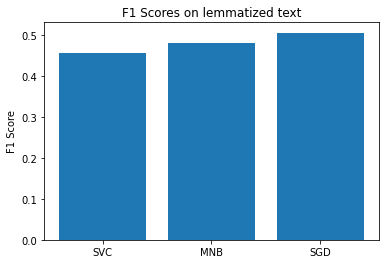

In [ ]:
#Bar plot on lemmatized
plt.figure()
labels = ['SVC', 'MNB', 'SGD']
y_axis = np.arange(len(labels))
values = [lemmatized_f1_svc, lemmatized_f1_mnb, lemmatized_f1_sgd]
plt.bar(y_axis, values, align='center')
plt.xticks(y_axis, labels)
plt.ylabel('F1 Score')
plt.title('F1 Scores on lemmatized text')

#plt.savefig(fname="Figures/Scores_on_lemmatized")
plt.show()


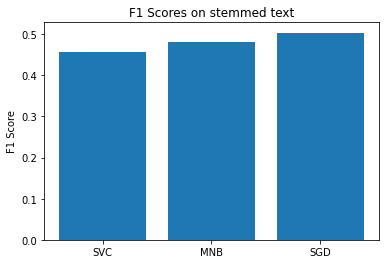

In [ ]:
#Bar plot on stemmed
plt.figure()
labels = ['SVC', 'MNB', 'SGD']
y_axis = np.arange(len(labels))
values = [stemmed_f1_svc, stemmed_f1_mnb, stemmed_f1_sgd]
plt.bar(y_axis, values, align='center')
plt.xticks(y_axis, labels)
plt.ylabel('F1 Score')
plt.title('F1 Scores on stemmed text')

#plt.savefig(fname="Figures/Scores_on_stemmed")
plt.show()


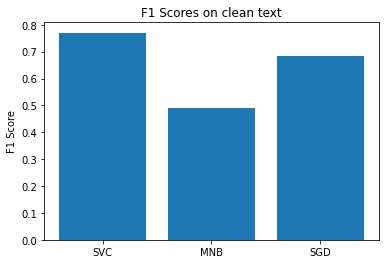

In [ ]:
#Bar plot on clean
plt.figure()
labels = ['SVC', 'MNB', 'SGD']
y_axis = np.arange(len(labels))
values = [clean_f1_svc, clean_f1_mnb, clean_f1_sgd]
plt.bar(y_axis, values, align='center')
plt.xticks(y_axis, labels)
plt.ylabel('F1 Score')
plt.title('F1 Scores on clean text')

#plt.savefig(fname="Figures/Scores_on_clean")
plt.show()


Evaluation

In [ ]:
#Optimizing the SVM score via hyperparameter tuning through GridSearch

# Make the pipeline
svc_pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LinearSVC()) ])

svc_pipeline.get_params()

{'memory': None,
 'steps': [('vect', CountVectorizer()),
  ('tfidf', TfidfTransformer()),
  ('clf', LinearSVC())],
 'verbose': False,
 'vect': CountVectorizer(),
 'tfidf': TfidfTransformer(),
 'clf': LinearSVC(),
 'vect__analyzer': 'word',
 'vect__binary': False,
 'vect__decode_error': 'strict',
 'vect__dtype': numpy.int64,
 'vect__encoding': 'utf-8',
 'vect__input': 'content',
 'vect__lowercase': True,
 'vect__max_df': 1.0,
 'vect__max_features': None,
 'vect__min_df': 1,
 'vect__ngram_range': (1, 1),
 'vect__preprocessor': None,
 'vect__stop_words': None,
 'vect__strip_accents': None,
 'vect__token_pattern': '(?u)\\b\\w\\w+\\b',
 'vect__tokenizer': None,
 'vect__vocabulary': None,
 'tfidf__norm': 'l2',
 'tfidf__smooth_idf': True,
 'tfidf__sublinear_tf': False,
 'tfidf__use_idf': True,
 'clf__C': 1.0,
 'clf__class_weight': None,
 'clf__dual': True,
 'clf__fit_intercept': True,
 'clf__intercept_scaling': 1,
 'clf__loss': 'squared_hinge',
 'clf__max_iter': 1000,
 'clf__multi_class': 'ov

In [ ]:
parameter_grid = { 'vect__max_features': [None, 100, 200, 400, 500, 1000, 2000, 3000, 4000, 5000, 6000,7000,10000,20000,30000,50000],
                'tfidf__use_idf' : [True, False],
                'tfidf__smooth_idf': [True, False],
                'vect__ngram_range': [(1,3), (1,1), (1,2)],
                'clf__C' : [0.1,0.2,0.3,0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5]
}
grid = GridSearchCV(svc_pipeline, parameter_grid, scoring='f1_micro', n_jobs=-1, refit=True, verbose=2)
grid.fit(balanced_train_set['cleantweetText'], balanced_train_set['label'])

print(grid.best_params_)
print(grid.best_estimator_)


Fitting 5 folds for each of 2880 candidates, totalling 14400 fits
{'clf__C': 0.6, 'tfidf__smooth_idf': True, 'tfidf__use_idf': True, 'vect__max_features': 7000, 'vect__ngram_range': (1, 1)}
Pipeline(steps=[('vect', CountVectorizer(max_features=7000)),
                ('tfidf', TfidfTransformer()), ('clf', LinearSVC(C=0.6))])


In [ ]:
#Score after parameter turning
print('F1 Score for test data ->' + str(grid.score(test_set['cleantweetText'],test_set['label'])))


F1 Score for test data ->0.6676431424766978


In [ ]:
grid.best_params_

{'clf__C': 0.6,
 'tfidf__smooth_idf': True,
 'tfidf__use_idf': True,
 'vect__max_features': 7000,
 'vect__ngram_range': (1, 1)}

F1 Score => 0.7725699067909454
Accuracy Score => 0.7725699067909454
Precision Score => 0.7725699067909454
Recall Score => 0.7725699067909454


c:\Users\teode\Documents\University\Year 3\COMP 3222 Machine Learning Technologies\Coursework\Development\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


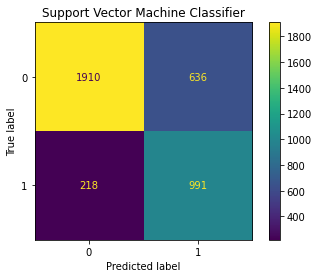

In [ ]:
#Manually adding the best params and evaluating the algorithm
svc_pipeline.set_params(clf__C=0.9)
svc_pipeline.set_params(tfidf__smooth_idf=True)
svc_pipeline.set_params(tfidf__use_idf=True)
svc_pipeline.set_params(vect__max_features=None)
svc_pipeline.set_params(vect__ngram_range=(1,1))

grid_search_svc_model = svc_pipeline.fit(balanced_train_set['cleantweetText'], balanced_train_set['label'])
grid_search_svc_pred = grid_search_svc_model.predict(test_set['cleantweetText'])

grid_search_svc_score = metrics.accuracy_score(test_set['label'], grid_search_svc_pred)
grid_search_svc_f1 = f1_score(test_set['label'], grid_search_svc_pred, average="micro")
grid_search_svc_precision = precision_score(test_set['label'], grid_search_svc_pred, average='micro')
grid_search_svc_recall = recall_score(test_set['label'], grid_search_svc_pred, average='micro')

print('F1 Score => ' + str(grid_search_svc_f1))
print('Accuracy Score => ' + str(grid_search_svc_score))
print('Precision Score => ' + str(grid_search_svc_precision))
print('Recall Score => ' + str(grid_search_svc_recall))


plot_confusion_matrix(grid_search_svc_model, test_set['cleantweetText'], test_set['label'])
plt.title('Support Vector Machine Classifier')
#plt.savefig('Figures/final_SVM')





Try the algorithm with more features

SVC F1 Score => 0.7989347536617842
Precision score => 0.7989347536617842
Recall score => 0.7989347536617842


c:\Users\teode\Documents\University\Year 3\COMP 3222 Machine Learning Technologies\Coursework\Development\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


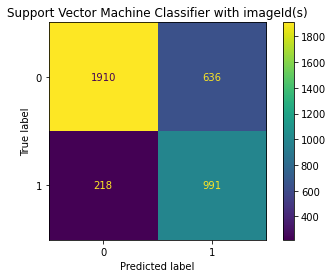

In [ ]:
big_train_set = balanced_train_set['cleantweetText'] + ' ' + balanced_train_set['imageId(s)']
big_test_set = test_set['cleantweetText'] + ' ' + test_set['imageId(s)']


svc_pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LinearSVC()) ])



end_svc_model = svc_pipeline.fit(big_train_set, balanced_train_set['label'])
end_svc_pred = end_svc_model.predict(big_test_set)

end_f1_svc = f1_score(test_set['label'], end_svc_pred, average="micro")
end_precision_svc = precision_score(test_set['label'], end_svc_pred, average="micro")
end_recall_svc = recall_score(test_set['label'], end_svc_pred, average="micro")

print('SVC F1 Score => ' + str(end_f1_svc) + '\n'+ 'Precision score => ' + str(end_precision_svc) + '\n' + 'Recall score => ' +str(end_recall_svc))

plot_confusion_matrix(grid_search_svc_model, big_test_set, test_set['label'])
plt.title('Support Vector Machine Classifier with imageId(s)')
#plt.savefig('Figures/extra_SVM')

Figure/Images Code

In [ ]:
# Data searches
#Add number of exclamations
#train_set['Exclamation occurrences'] = train_set.iloc[:,1].apply(lambda x: (len(re.findall('!',x))))
#Add number of emojis
#train_set['Emoji occurrences'] = train_set.iloc[:,1].apply(lambda x: len(re.findall( r"(:[^:]*:)", x)))
#Add number of hashtags
#train_set['Hashtag occurrences'] = train_set.iloc[:,1].apply(lambda x: len(re.findall(r'\B#\w*[a-zA-Z]+\w*', x)))
#Add lenght of tweetText
#train_set['tweetText_length'] = train_set['tweetText'].str.len()


#train_set.head()

In [ ]:
#def emoji_graph(train_set):
#    g_realPosts = train_set[train_set['label']=='real']
#    g_fakePosts = train_set[train_set['label']=='fake']
    
#    mean_false=g_fakePosts['Emoji occurrences'].mean()
#    mean_true= g_realPosts['Emoji occurrences'].mean()
    
    
#    plt.figure()
#    labels = ['Real', 'Fake']
#    y_axis = np.arange(len(labels))
#    values = [mean_true, mean_false]
#    plt.bar(y_axis, values, align='center', alpha=0.5)
#    plt.xticks(y_axis, labels)
#    plt.ylabel('Num. of occurrences')
#    plt.title('Mean number of emoji occurrences in Real and Fake posts')

#   plt.savefig(fname="Figures/Num_of_emojis")
#    plt.show()

#emoji_graph(train_set)

In [ ]:
#def hashtag_graph(train_set):
#    g_realPosts = train_set[train_set['label']=='real']
#    g_fakePosts = train_set[train_set['label']=='fake']
    
#    mean_false=g_fakePosts['Hashtag occurrences'].mean()
#    mean_true= g_realPosts['Hashtag occurrences'].mean()
    
    
#    plt.figure()
#    labels = ['Real', 'Fake']
#    y_axis = np.arange(len(labels))
#    values = [mean_true, mean_false]
#    plt.bar(y_axis, values, align='center', alpha=0.5)
#    plt.xticks(y_axis, labels)
#    plt.ylabel('Num. of occurrences')
#    plt.title('Mean number of hashtag occurrences in Real and Fake posts')
#
#   plt.savefig(fname="Figures/Num_of_hashtags")
#    plt.show()

# hashtag_graph(train_set)

In [ ]:
#def exclamation_graph(train_set):
#    g_realPosts = train_set[train_set['label']=='real']
#    g_fakePosts = train_set[train_set['label']=='fake']
    
#    mean_false=g_fakePosts['Exclamation occurrences'].mean()
#    mean_true= g_realPosts['Exclamation occurrences'].mean()
    
    
#    plt.figure()
#    labels = ['Real', 'Fake']
#    y_axis = np.arange(len(labels))
#    values = [mean_true, mean_false]
#    plt.bar(y_axis, values, align='center', alpha=0.5)
#    plt.xticks(y_axis, labels)
#    plt.ylabel('Num. of occurrences')
#    plt.title('Mean number of exclamation occurrences in Real and Fake posts')

#    plt.savefig(fname="Figures/Num_of_exclamations")
#    plt.show()

#exclamation_graph(train_set)

In [ ]:
#Length of tweets
#def tweet_length_graph(train_set):
#    g_realPosts = train_set[train_set['label']=='real']
#    g_fakePosts = train_set[train_set['label']=='fake']
    
#    mean_false=g_fakePosts['tweetText_length'].mean()
#    mean_true= g_realPosts['tweetText_length'].mean()
    
    
#    plt.figure()
#    labels = ['Real', 'Fake']
#    y_axis = np.arange(len(labels))
#    values = [mean_true, mean_false]
#    plt.bar(y_axis, values, align='center', alpha=0.5)
#    plt.xticks(y_axis, labels)
#    plt.ylabel('tweetText length')
#    plt.title('Mean length of tweets in Real and Fake posts')

#    plt.savefig(fname="Figures/Length_of_tweets")
#    plt.show()

#tweet_length_graph(train_set)


